In [2]:
import os
import datetime
import parser

import pandas as pd
import numpy as np
import scipy.stats as stats
import arviz as az
import pymc3 as pm
import sklearn

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
az.rcParams['stats.hdi_prob'] = 0.89
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['legend.fontsize']=12
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['figure.titlesize']=15

np.random.seed(42)

%matplotlib inline
%config Inline.figure_format = 'retina'

#### Load data

In [3]:
HOUSING_PATH = os.path.join("../datasets", "housing")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

#### Stratified Sampling by income category

In [4]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set, housing):
    set_.drop("income_cat", axis=1, inplace=True)    

#### Feature Transformers
Steps:

1. Cat pipeline
   - one hot encode for cat vars  
  
  
2. Num pipeline
    - impute na
    - add some new features
    - standardize for num vars


3. Combine with ColumnTransformer

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [36]:
num_cols = strat_train_set.select_dtypes(include='number').columns.difference(['median_house_value']).sort_values()
cat_cols = strat_train_set.select_dtypes(include='object').columns

In [53]:
num_ix_mapper = pd.Series(index=num_cols, data=range(len(num_cols)))
rooms_ix, households_ix, pop_ix, bedrooms_ix = num_ix_mapper[['total_rooms', 'households', 'population', 'total_bedrooms']]

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, pop_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [61]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('attribs_adder', AttributesAdder(add_bedrooms_per_room=True)),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", OneHotEncoder(), cat_cols),
])

In [63]:
train_X = full_pipeline.fit_transform(strat_train_set)
train_y = strat_train_set['median_house_value']

test_X = full_pipeline.transform(strat_test_set)
test_y = strat_test_set['median_house_value']

#### Exercise 1. Try SVM with GridSearchCV

In [66]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [78]:
param_grid = [
    {'kernel': ['linear'], "C": [0.5, 1, 2, 4]},
    {'kernel': ['rbf'], "C": [0.5, 1, 2, 4], "gamma": [0.05, 0.1, 0.5, 1]}
]

grid_search = GridSearchCV(SVR(), param_grid, cv = 5, n_jobs=4,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2)

grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  8.9min finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid=[{'C': [0.5, 1, 2, 4], 'kernel': ['linear']},
                         {'C': [0.5, 1, 2, 4], 'gamma': [0.05, 0.1, 0.5, 1],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [80]:
np.sqrt(-grid_search.best_score_)

98407.97874755673

In [81]:
grid_search.best_params_

{'C': 4, 'kernel': 'linear'}

In [87]:
cvres = grid_search.cv_results_
for mean_score, params in sorted(zip(cvres['mean_test_score'], cvres['params']), key=lambda x: -x[0]):
    print(np.sqrt(-mean_score), params)

98407.97874755673 {'C': 4, 'kernel': 'linear'}
107136.26398576611 {'C': 2, 'kernel': 'linear'}
112571.9845974018 {'C': 1, 'kernel': 'linear'}
115595.79530238075 {'C': 0.5, 'kernel': 'linear'}
117797.57469769163 {'C': 4, 'gamma': 0.1, 'kernel': 'rbf'}
117854.46605174112 {'C': 4, 'gamma': 0.05, 'kernel': 'rbf'}
118361.99343356273 {'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}
118379.00983337601 {'C': 2, 'gamma': 0.05, 'kernel': 'rbf'}
118573.69774338815 {'C': 4, 'gamma': 0.5, 'kernel': 'rbf'}
118638.14057023903 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
118646.48325535003 {'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}
118750.7191426293 {'C': 2, 'gamma': 0.5, 'kernel': 'rbf'}
118776.0249577243 {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
118782.55031155302 {'C': 0.5, 'gamma': 0.05, 'kernel': 'rbf'}
118796.03701146161 {'C': 4, 'gamma': 1, 'kernel': 'rbf'}
118832.52522524683 {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
118857.90522178201 {'C': 2, 'gamma': 1, 'kernel': 'rbf'}
118874.89705492764 {'C': 0.5, 'gamma': 

#### Exercise 2. Try GBM with RandomizedSearchCV

In [134]:
from sklearn.ensemble import GradientBoostingRegressor

param_distr = {
    'loss': ['ls', 'huber'],
    'learning_rate': stats.beta(a=2, b=3),
    'n_estimators': stats.poisson(mu=400)
}

gbr = GradientBoostingRegressor()
rnd_search = RandomizedSearchCV(gbr, param_distr, n_jobs=4, cv = 5, 
                                scoring = 'neg_mean_squared_error')

In [135]:
rnd_search.fit(train_X, train_y)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=4,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12c991150>,
                                        'loss': ['ls', 'huber'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12cb59c90>},
                   scoring='neg_mean_squared_error')

In [136]:
np.sqrt(-rnd_search.best_score_)

47909.740321849975

In [141]:
rnd_search.best_estimator_

GradientBoostingRegressor(learning_rate=0.18291786545248606, loss='huber',
                          n_estimators=451)

In [142]:
rndres = rnd_search.cv_results_
for mean_score, params in sorted(zip(rndres['mean_test_score'], rndres['params']), key=lambda x: -x[0]):
    print(np.sqrt(-mean_score), params)

47909.740321849975 {'learning_rate': 0.18291786545248606, 'loss': 'huber', 'n_estimators': 451}
47986.054771962044 {'learning_rate': 0.2602220907433682, 'loss': 'ls', 'n_estimators': 426}
48136.786179968105 {'learning_rate': 0.3781475651808444, 'loss': 'huber', 'n_estimators': 410}
48220.24013647533 {'learning_rate': 0.38379764988574694, 'loss': 'huber', 'n_estimators': 415}
48243.00514886824 {'learning_rate': 0.3285220060068744, 'loss': 'ls', 'n_estimators': 391}
48286.52839343767 {'learning_rate': 0.1879322789889023, 'loss': 'huber', 'n_estimators': 401}
48371.361117778266 {'learning_rate': 0.40283681298841245, 'loss': 'huber', 'n_estimators': 406}
49499.847492802095 {'learning_rate': 0.08103668394718797, 'loss': 'huber', 'n_estimators': 413}
50377.09902496312 {'learning_rate': 0.5382423197101761, 'loss': 'ls', 'n_estimators': 423}
52643.78477466056 {'learning_rate': 0.8502045692168247, 'loss': 'huber', 'n_estimators': 417}


In [143]:
feature_importances=rnd_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_cols.tolist() + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.5400896934203869, 'median_income'),
 (0.16998416389034032, 'INLAND'),
 (0.09197642811270292, 'pop_per_hhold'),
 (0.07463681520269037, 'longitude'),
 (0.05858383287811106, 'latitude'),
 (0.027606621066973386, 'housing_median_age'),
 (0.010932494180472489, 'rooms_per_hhold'),
 (0.00576681436283936, 'bedrooms_per_room'),
 (0.005225013085998055, 'NEAR BAY'),
 (0.003538179612449058, 'total_rooms'),
 (0.0034302060838387323, 'total_bedrooms'),
 (0.0026523943626369944, 'households'),
 (0.0025974664236531183, 'NEAR OCEAN'),
 (0.0017416031390033225, 'population'),
 (0.0012101959429533073, '<1H OCEAN'),
 (2.8078234950527344e-05, 'ISLAND')]

#### Exercise 3. Add a transformer to select only the most important attributes

In [144]:
class TopKAttributesPicker(BaseEstimator, TransformerMixin):
    def __init__(self, k):
        self.k = k
    def fit(self, X, y):
        gbr = GradientBoostingRegressor(loss='huber', n_estimators=500, learning_rate=0.2)
        gbr.fit(X, y)
        self.top_k_ix = np.argsort(-gbr.feature_importances_)[:self.k]
        return self
    def transform(self, X):
        return X[:, self.top_k_ix]

In [145]:
topk_picker = TopKAttributesPicker(k=5)
tmp_topk_X = topk_picker.fit_transform(train_X[:100,:], train_y[:100])
tmp_topk_X.shape

(100, 5)

#### Exercise 4. Create a single pipeline for both data prep plus prediction

In [128]:
train_X.shape

(16512, 16)

In [152]:
param_grid = {
    "topk_picker__k": [5, 9, 13],
    "gbr__learning_rate": [0.7, 0.5, 0.3],
    "gbr__n_estimators": [300, 600, 900],
}

e2e_pipeline = Pipeline([
    ('data_preper', full_pipeline),
    ('topk_picker', TopKAttributesPicker(k=5)),
    ('gbr', GradientBoostingRegressor(loss='huber', random_state=42)),
    ])

cv_reg = GridSearchCV(e2e_pipeline, param_grid = param_grid, cv = 4, n_jobs=4,
                     scoring='neg_mean_squared_error', refit=True,
                     return_train_score=True)

In [153]:
cv_reg.fit(strat_train_set.drop('median_house_value', axis=1), strat_train_set['median_house_value'])

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('data_preper',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          AttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'population', 'total_be

In [154]:
np.sqrt(-cv_reg.best_score_)

47981.60583888648

In [155]:
cv_reg.best_params_

{'gbr__learning_rate': 0.3, 'gbr__n_estimators': 600, 'topk_picker__k': 9}

#### Predict on test set

In [156]:
test_y_hat = cv_reg.predict(strat_test_set.drop('median_house_value', axis=1))

In [172]:
from sklearn.metrics import mean_squared_error
test_rmse = np.sqrt(mean_squared_error(strat_test_set['median_house_value'], test_y_hat))
pred_diff = test_y_hat - strat_test_set['median_house_value'].to_numpy()

In [161]:
test_rmse

44325.46634859067

In [173]:
az.summary(pred_diff, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
x,-2568.184,44256.365,-65111.132,59324.05


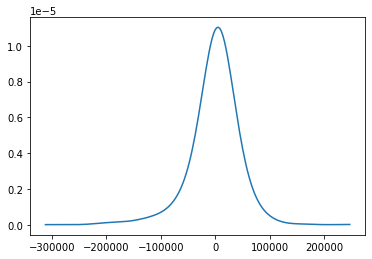

In [174]:
az.plot_kde(pred_diff)

In [175]:
pd.Series(pred_diff).describe()

count      4128.000000
mean      -2568.184028
std       44256.365318
min     -312219.138649
25%      -18862.749411
50%        1515.400589
75%       19847.317865
max      247036.392116
dtype: float64

In [180]:
strat_test_set.iloc[np.argmax(pred_diff), :]

longitude               -118.33
latitude                  34.15
housing_median_age           39
total_rooms                 493
total_bedrooms              168
population                  259
households                  138
median_income            2.3667
median_house_value        17500
ocean_proximity       <1H OCEAN
Name: 5887, dtype: object

In [181]:
test_y_hat[np.argmax(pred_diff)]

264536.39211553585

In [182]:
strat_test_set.iloc[np.argmin(pred_diff), :]

longitude                -117.31
latitude                    33.1
housing_median_age            15
total_rooms                 2392
total_bedrooms               446
population                   747
households                   421
median_income             3.5341
median_house_value        500001
ocean_proximity       NEAR OCEAN
Name: 15288, dtype: object

In [183]:
test_y_hat[np.argmin(pred_diff)]

187781.86135054473

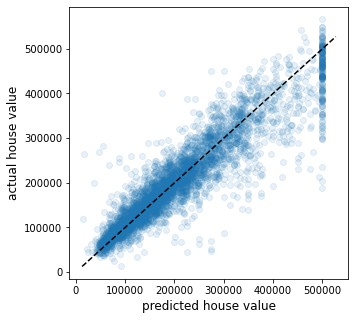

In [209]:
plt.figure(figsize=(5,5))
plt.scatter(strat_test_set['median_house_value'], test_y_hat, alpha=0.1)
plt.plot(np.sort(test_y_hat)[:-10], np.sort(test_y_hat)[:-10], 'k--')
plt.xlabel("predicted house value")
plt.ylabel("actual house value")
pass